In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from palettable.tableau import Tableau_10

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37953/status,
Dashboard: /proxy/37953/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43487,Workers: 4
Dashboard: /proxy/37953/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:42919,Total threads: 4
Dashboard: /proxy/35467/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:42029,


In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

In [5]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'cmip6', 'reanalysis']

Load reanalysis and CMIP6 multimodel mean

In [7]:
psl = {}
for k in keys:
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc')['psl'].mean('time')

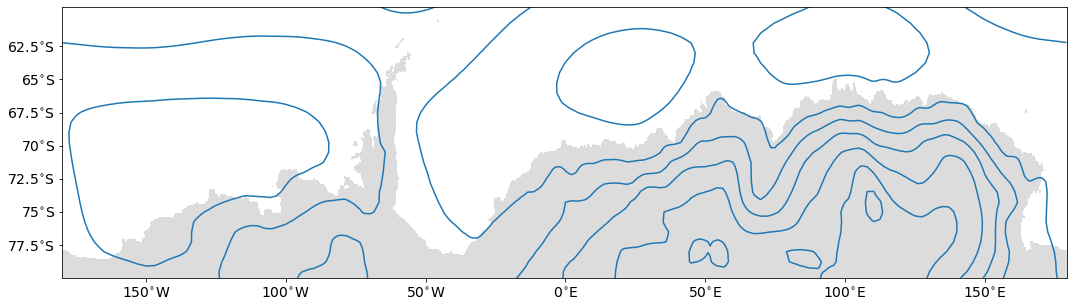

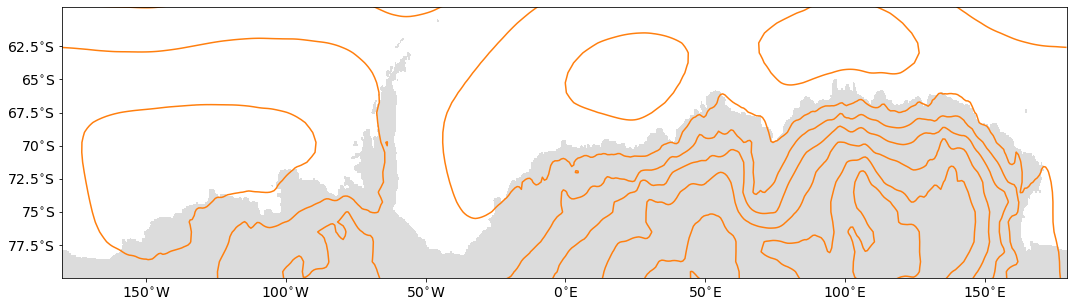

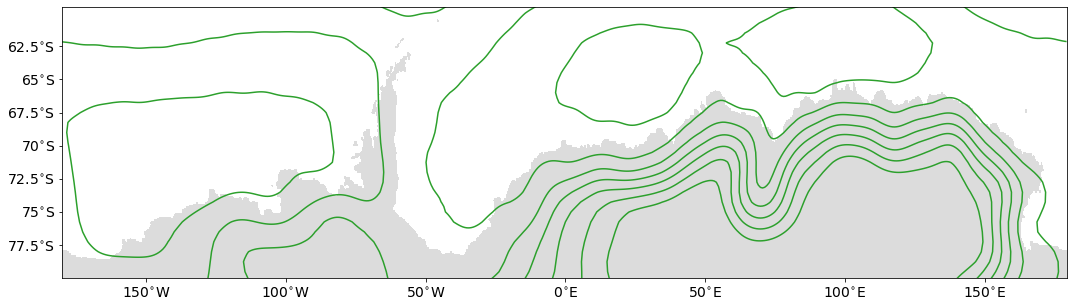

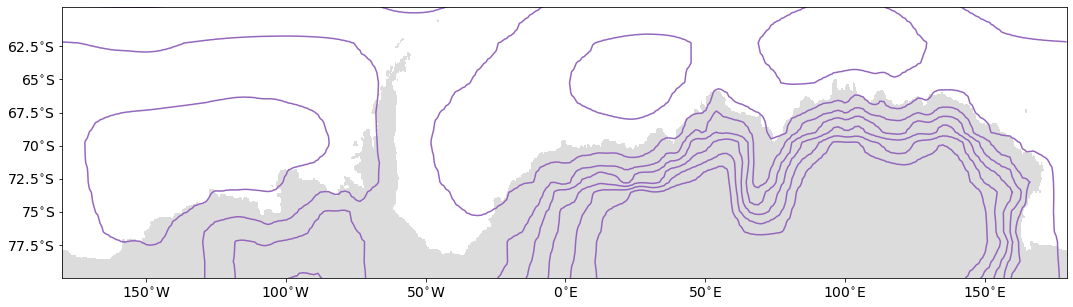

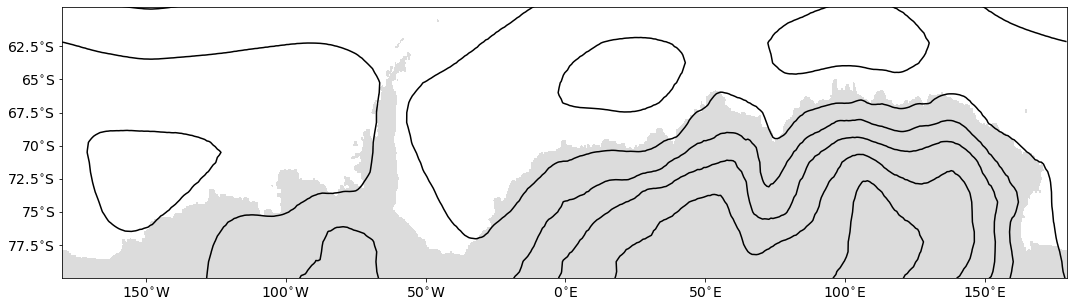

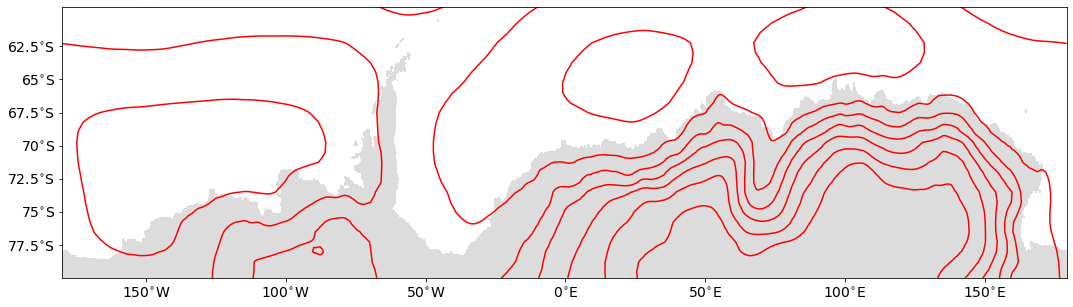

In [9]:
for k, clr in zip(keys, [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4], 'k', 'r']):
    plt.rcParams['font.size'] = 14
    fig = plt.figure(figsize = (18, 5))
    ax = fig.add_subplot()
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    ax.set_xticks(np.arange(-150, 200, 50))
    ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                                '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
                linewidths = 0.5, zorder = 0)

    ax.contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100, levels = np.arange(983, 1017, 5), 
                   colors = [clr], zorder = 1)

In [12]:
psl_20052015 = xr.open_dataset('../data/psl-monthly-1979_2015-cmip6.nc')['psl'].sel(time = slice('2005-01-01', None)).mean('time')

In [17]:
psl_20802100 = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp85.nc')['psl'].sel(time = slice('2080-01-01', None)).mean('time')

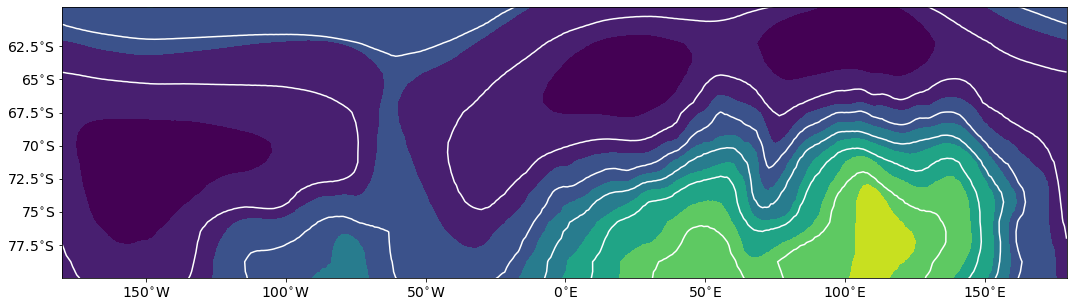

In [22]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 5))
ax = fig.add_subplot()
ax.set_xlim([-180, 179.25])
ax.set_ylim([-80, -59.5])
ax.set_yticks(np.arange(-77.5, -60, 2.5))
ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                    '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
ax.set_xticks(np.arange(-150, 200, 50))
ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
# Land
ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
            linewidths = 0.5, zorder = 0)

ax.contourf(psl_20052015['lon'], psl_20052015['lat'],psl_20052015/100, levels = np.arange(983, 1017, 5), 
               cmap = 'viridis', extend = 'both', zorder = 1)

ax.contour(psl_20802100['lon'], psl_20802100['lat'],psl_20802100/100, levels = np.arange(983, 1017, 5), 
               colors= ['white'], zorder = 1)

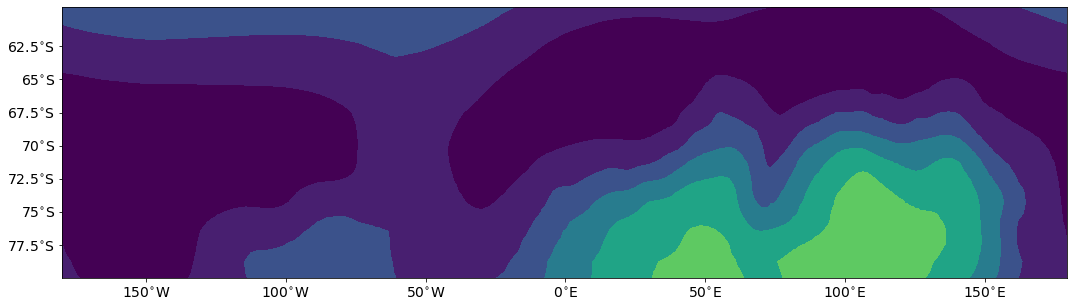

In [ ]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 5))
ax = fig.add_subplot()
ax.set_xlim([-180, 179.25])
ax.set_ylim([-80, -59.5])
ax.set_yticks(np.arange(-77.5, -60, 2.5))
ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                    '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
ax.set_xticks(np.arange(-150, 200, 50))
ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
# Land
ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
            linewidths = 0.5, zorder = 0)

ax.contourf(psl_20802100['lon'], psl_20802100['lat'],psl_20802100/100, levels = np.arange(983, 1017, 5), 
               cmap = 'viridis', extend = 'both', zorder = 1)